In [1]:
import os
import joblib
import warnings

import numpy as np # linear algebra
import pandas as pd # data processing,
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/life-style-data/Final_data.csv
/kaggle/input/life-style-data/expanded_fitness_data.csv


## Read Data File

In [2]:
df=pd.read_csv("/kaggle/input/life-style-data/Final_data.csv")
df.columns 

Index(['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'Max_BPM', 'Avg_BPM',
       'Resting_BPM', 'Session_Duration (hours)', 'Calories_Burned',
       'Workout_Type', 'Fat_Percentage', 'Water_Intake (liters)',
       'Workout_Frequency (days/week)', 'Experience_Level', 'BMI',
       'Daily meals frequency', 'Physical exercise', 'Carbs', 'Proteins',
       'Fats', 'Calories', 'meal_name', 'meal_type', 'diet_type', 'sugar_g',
       'sodium_mg', 'cholesterol_mg', 'serving_size_g', 'cooking_method',
       'prep_time_min', 'cook_time_min', 'rating', 'Name of Exercise', 'Sets',
       'Reps', 'Benefit', 'Burns Calories (per 30 min)', 'Target Muscle Group',
       'Equipment Needed', 'Difficulty Level', 'Body Part', 'Type of Muscle',
       'Workout', 'BMI_calc', 'cal_from_macros', 'pct_carbs', 'protein_per_kg',
       'pct_HRR', 'pct_maxHR', 'cal_balance', 'lean_mass_kg', 'expected_burn',
       'Burns Calories (per 30 min)_bc', 'Burns_Calories_Bin'],
      dtype='object')

In [3]:
df.sample()

,Age,Gender,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Calories_Burned,Workout_Type,...,cal_from_macros,pct_carbs,protein_per_kg,pct_HRR,pct_maxHR,cal_balance,lean_mass_kg,expected_burn,Burns Calories (per 30 min)_bc,Burns_Calories_Bin
17107,44.0,Female,59.31,1.52,177.0,135.85,55.9,1.58,1851.44,Strength,...,3181.41,0.499753,2.676109,0.660198,0.767514,-121.44,43.826108,1098.4476,8.178388e+19,Medium


## Take Some Features

In [4]:
# Keep relevant columns
meal_cols = [
    'meal_name', 'meal_type', 'diet_type', 'Calories', 'Proteins', 'Carbs', 'Fats',
    'cooking_method', 'rating', 'prep_time_min', 'cook_time_min'
]
df_meals = df[meal_cols].dropna().drop_duplicates().reset_index(drop=True)


## Preprocess

In [5]:
# Normalize macros for fair comparison
df_meals['Calories_norm'] = df_meals['Calories'] / df_meals['Calories'].max()
df_meals['Proteins_norm'] = df_meals['Proteins'] / df_meals['Proteins'].max()
df_meals['Carbs_norm'] = df_meals['Carbs'] / df_meals['Carbs'].max()
df_meals['Fats_norm'] = df_meals['Fats'] / df_meals['Fats'].max()


## Recommendation Function

In [6]:
def recommend_meals(user_bmi, target_calories, diet_type=None, meal_type=None, n=5):
    """
    Recommend meals based on nutritional similarity to target macros & calories.
    """
    # Target profile (user preference)
    target = pd.DataFrame({
        'Calories_norm': [target_calories / df_meals['Calories'].max()],
        'Proteins_norm': [0.5],   # target 50% protein
        'Carbs_norm': [0.3],      # 30% carbs
        'Fats_norm': [0.2]        # 30% fats
    })

    # Compute cosine similarity between meals and target
    meal_features = df_meals[['Calories_norm', 'Proteins_norm', 'Carbs_norm', 'Fats_norm']]
    similarity = cosine_similarity(meal_features, target)
    df_meals['similarity'] = similarity

    # Apply filters if provided
    filtered = df_meals.copy()
    if diet_type:
        filtered = filtered[filtered['diet_type'].str.contains(diet_type, case=False, na=False)]
    if meal_type:
        filtered = filtered[filtered['meal_type'].str.contains(meal_type, case=False, na=False)]

    # Sort by similarity
    recs = filtered.sort_values(by='similarity', ascending=False).head(n)

    return recs[['meal_name', 'meal_type', 'diet_type', 'Calories', 'Proteins', 'Carbs', 'Fats',
                 'cooking_method', 'rating', 'prep_time_min', 'cook_time_min']]

## Call Function

In [7]:
recommendations = recommend_meals(
    user_bmi=27, 
    target_calories=500, 
    diet_type="Balanced", 
    meal_type="Lunch", 
    n=5
)

print("🍽️ Recommended Meals:")
print(recommendations)

🍽️ Recommended Meals:
      meal_name meal_type diet_type  Calories  Proteins   Carbs    Fats  \
6293      Other     Lunch  Balanced    1182.0    133.88  333.59   88.63   
18693     Other     Lunch  Balanced    1423.0    155.51  389.85  102.92   
5487      Other     Lunch  Balanced    1222.0    127.63  318.95   84.25   
1370      Other     Lunch  Balanced     970.0    124.09  309.34   82.73   
2776      Other     Lunch  Balanced    1296.0    139.79  349.94   92.83   

      cooking_method  rating  prep_time_min  cook_time_min  
6293           Fried    4.32          55.54          86.42  
18693        Roasted    2.19          39.06          38.36  
5487           Fried    3.27           9.78         101.43  
1370           Baked    4.61          20.16         105.22  
2776          Boiled    2.37          24.94          12.92  


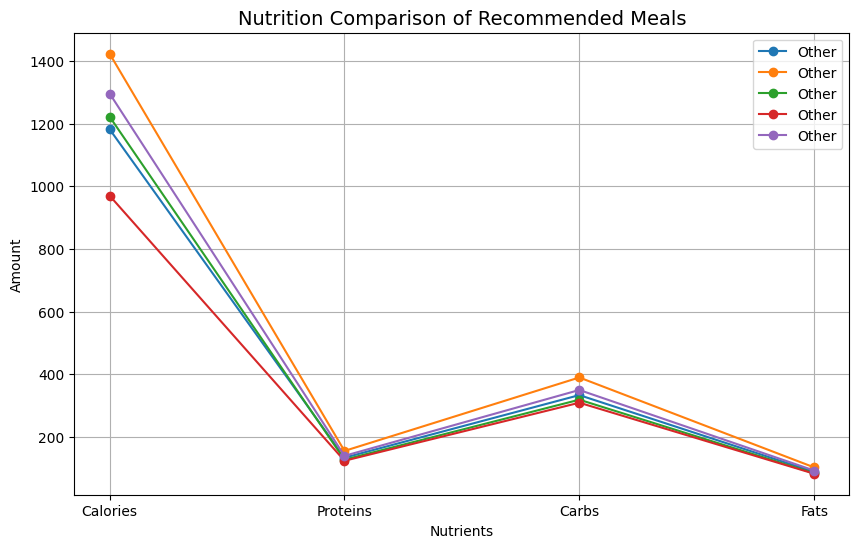

In [8]:
def visualize_meals(recs):
    """
    Show nutrition comparison across recommended meals.
    """
    nutrients = ['Calories', 'Proteins', 'Carbs', 'Fats']
    plt.figure(figsize=(10,6))
    for _, row in recs.iterrows():
        plt.plot(nutrients, [row[n] for n in nutrients], marker='o', label=row['meal_name'])

    plt.title('Nutrition Comparison of Recommended Meals', fontsize=14)
    plt.xlabel('Nutrients')
    plt.ylabel('Amount')
    plt.legend()
    plt.grid(True)
    plt.show()

visualize_meals(recommendations)

## The problem handling

In [9]:
df['meal_name']

0        Other
1        Other
2        Other
3        Other
4        Other
         ...  
19995    Other
19996    Other
19997    Other
19998    Other
19999    Other
Name: meal_name, Length: 20000, dtype: object

In [10]:
df['meal_name'] = (
    df['cooking_method'].fillna('Unknown').astype(str) + " " +
    df['diet_type'].fillna('Balanced').astype(str) + " " +
    df['meal_type'].fillna('Meal').astype(str)
).str.title()


In [11]:
print(df['meal_name'].head())


0       Grilled Vegan Lunch
1    Fried Vegetarian Lunch
2    Boiled Paleo Breakfast
3         Fried Paleo Lunch
4     Baked Vegan Breakfast
Name: meal_name, dtype: object


## New version after handling logical error 

In [12]:
# Ensure meaningful meal names (your version)
df['meal_name'] = (
    df['cooking_method'].fillna('Unknown').astype(str) + " " +
    df['diet_type'].fillna('Balanced').astype(str) + " " +
    df['meal_type'].fillna('Meal').astype(str)
).str.title()

# Drop duplicates and missing values
df = df.dropna(subset=['Calories', 'Proteins', 'Carbs', 'Fats'])
df = df.drop_duplicates(subset=['meal_name'])

## Recommended Function 

In [13]:
def recommend_meal(meal_name, top_n=5):
    if meal_name not in df['meal_name'].values:
        print(f"Meal '{meal_name}' not found. Please choose a valid one.")
        return None

    # Use nutritional and diet-type features
    features = ['Calories', 'Proteins', 'Carbs', 'Fats']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    # Compute similarity
    sim_matrix = cosine_similarity(X_scaled)

    # Get index of the meal
    idx = df.index[df['meal_name'] == meal_name][0]

    # Sort by similarity
    sim_scores = list(enumerate(sim_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top similar meals
    top_meals = [i[0] for i in sim_scores[1:top_n+1]]
    recommendations = df.iloc[top_meals][['meal_name', 'meal_type', 'diet_type', 
                                          'Calories', 'Proteins', 'Carbs', 'Fats', 
                                          'cooking_method']]
    
    print(f"\n🍽️ Recommended Meals similar to: **{meal_name}**")
    return recommendations


In [14]:
sample_meal = df['meal_name'].iloc[3]  # Example meal
recommendations = recommend_meal(sample_meal, top_n=5)
print(recommendations)



🍽️ Recommended Meals similar to: **Fried Paleo Lunch**
                      meal_name  meal_type   diet_type  Calories  Proteins  \
463  Steamed Balanced Breakfast  Breakfast    Balanced    2576.0     82.25   
211  Baked Vegetarian Breakfast  Breakfast  Vegetarian    2858.0     71.87   
11           Grilled Keto Snack      Snack        Keto    2232.0     93.27   
165          Raw Balanced Snack      Snack    Balanced    2540.0     80.41   
5            Steamed Keto Snack      Snack        Keto    2767.0     67.92   

      Carbs   Fats cooking_method  
463  206.59  55.03        Steamed  
211  180.09  48.24          Baked  
11   231.16  61.23        Grilled  
165  198.91  53.44            Raw  
5    170.86  46.06        Steamed  


/tmp/ipykernel_13/3771634114.py:14: UserWarning: Glyph 127835 (\N{CURRY AND RICE}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127835 (\N{CURRY AND RICE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


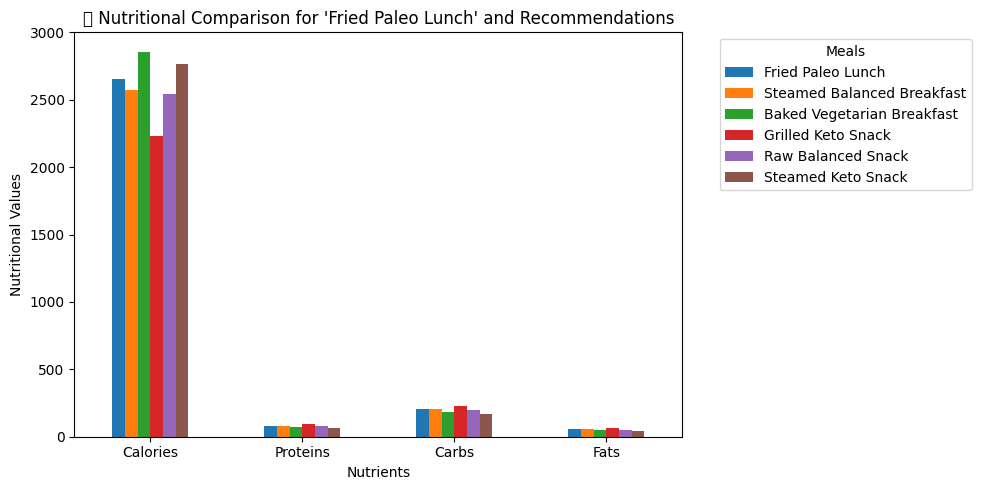

In [15]:
def plot_meal_comparison(base_meal, rec_meals):
    meals_to_plot = pd.concat([
        df[df['meal_name'] == base_meal][['meal_name', 'Calories', 'Proteins', 'Carbs', 'Fats']],
        rec_meals[['meal_name', 'Calories', 'Proteins', 'Carbs', 'Fats']]
    ])
    
    meals_to_plot.set_index('meal_name', inplace=True)
    meals_to_plot.T.plot(kind='bar', figsize=(10,5))
    plt.title(f"🍛 Nutritional Comparison for '{base_meal}' and Recommendations")
    plt.ylabel("Nutritional Values")
    plt.xlabel("Nutrients")
    plt.xticks(rotation=0)
    plt.legend(title="Meals", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Visualize
plot_meal_comparison(sample_meal, recommendations)


## Check after saving the model

In [16]:
# Ensure proper meal names
df['meal_name'] = (
    df['cooking_method'].fillna('Unknown').astype(str) + " " +
    df['diet_type'].fillna('Balanced').astype(str) + " " +
    df['meal_type'].fillna('Meal').astype(str)
).str.title()

# Clean and deduplicate
df = df.dropna(subset=['Calories', 'Proteins', 'Carbs', 'Fats'])
df = df.drop_duplicates(subset=['meal_name'])

# Feature selection
features = ['Calories', 'Proteins', 'Carbs', 'Fats']

# Scale nutritional values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Compute cosine similarity matrix
similarity_matrix = cosine_similarity(X_scaled)

# ✅ Save everything for deployment
joblib.dump(scaler, "scaler_meal_recommender.pkl")
joblib.dump(similarity_matrix, "meal_similarity_matrix.pkl")
df.to_csv("meal_metadata.csv", index=False)

print("✅ Model, Scaler, and Metadata saved successfully!")

# ✅ Save everything for deployment
joblib.dump(scaler, "scaler_meal_recommender.pkl")
joblib.dump(similarity_matrix, "meal_similarity_matrix.pkl")
df.to_csv("meal_metadata.csv", index=False)

print("✅ Model, Scaler, and Metadata saved successfully!")

✅ Model, Scaler, and Metadata saved successfully!
✅ Model, Scaler, and Metadata saved successfully!


## Call the model to use

In [17]:
# Load saved model components
scaler = joblib.load("scaler_meal_recommender.pkl")
similarity_matrix = joblib.load("meal_similarity_matrix.pkl")
df = pd.read_csv("meal_metadata.csv")

def recommend_meal(meal_name, top_n=5):
    if meal_name not in df['meal_name'].values:
        return f"Meal '{meal_name}' not found. Try another one."
    
    idx = df.index[df['meal_name'] == meal_name][0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    top_meals = [i[0] for i in sim_scores[1:top_n+1]]
    return df.iloc[top_meals][['meal_name', 'meal_type', 'diet_type', 'Calories', 'Proteins', 'Carbs', 'Fats', 'cooking_method']]

# Example
meal = df['meal_name'].iloc[0]
print(recommend_meal(meal))


                     meal_name  meal_type diet_type  Calories  Proteins  \
125            Raw Vegan Lunch      Lunch     Vegan    1791.0    107.75   
76   Boiled Low-Carb Breakfast  Breakfast  Low-Carb    1231.0    124.84   
134  Boiled Balanced Breakfast  Breakfast  Balanced    1595.0    114.79   
59             Raw Vegan Snack      Snack     Vegan    1410.0    118.76   
86      Roasted Low-Carb Snack      Snack  Low-Carb    1440.0    121.29   

      Carbs   Fats cooking_method  
125  269.88  71.92            Raw  
76   312.49  83.15         Boiled  
134  284.43  76.75         Boiled  
59   295.15  79.09            Raw  
86   302.12  80.75        Roasted  
